## Re-weighting high dimensional data

Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016.

It is very common that one has two distributions $p_0(x)$ and $p_1(x)$ and  would like to make one look like the other. This happens for instance in high energy physics where we have a simulation of the data that isn't perfect and we want to make it look like the real data. In this case we are going to "reweight" data from one distribution so that the result looks like the other. For more on this topic, see Alex Rogozhnikov's nice [blog post](http://arogozhnikov.github.io/2015/10/09/gradient-boosted-reweighter.html)

We reuse the toy distribution used in [Parameterized inference from multidimensional data](./Parameterized%20inference%20from%20multidimensional%20data.ipynb). 

We will compare three types of reweighting:
   * exact reweighting -- not usually possible, but it's nice for comparisons
   * reweighting based on Alex's gradient-boosting `GBRweighter`
   * reweighting based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) using the [carl](https://github.com/diana-hep/carl) package to approximate the likelihood ratio by first training a neural network classifier and then calibrating the output to be the likelihood ratio. Any other type of classifier could also be used.

We will compare the exact weights to the two approximate techniques and use a `discriminator` to distinguish between target and the reweighted distribution using the different techniques.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.set_cmap("viridis")

import numpy as np
import theano
from scipy.stats import chi2
from itertools import product

np.random.seed(314)

### Create model and generate two artificial datasets

These are just toy distributions used to make some mildly complicated 5-d data.


In [27]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

import pdb

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=1, sigma=1),
        Normal(mu=-1, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

p1 = LinearTransform(Join(components=[
        Normal(mu=0, sigma=1),
        Normal(mu=0, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)


In [28]:
n_samples = 100000
X0 = p0.rvs(n_samples,random_state=777)
X1 = p1.rvs(n_samples,random_state=777)

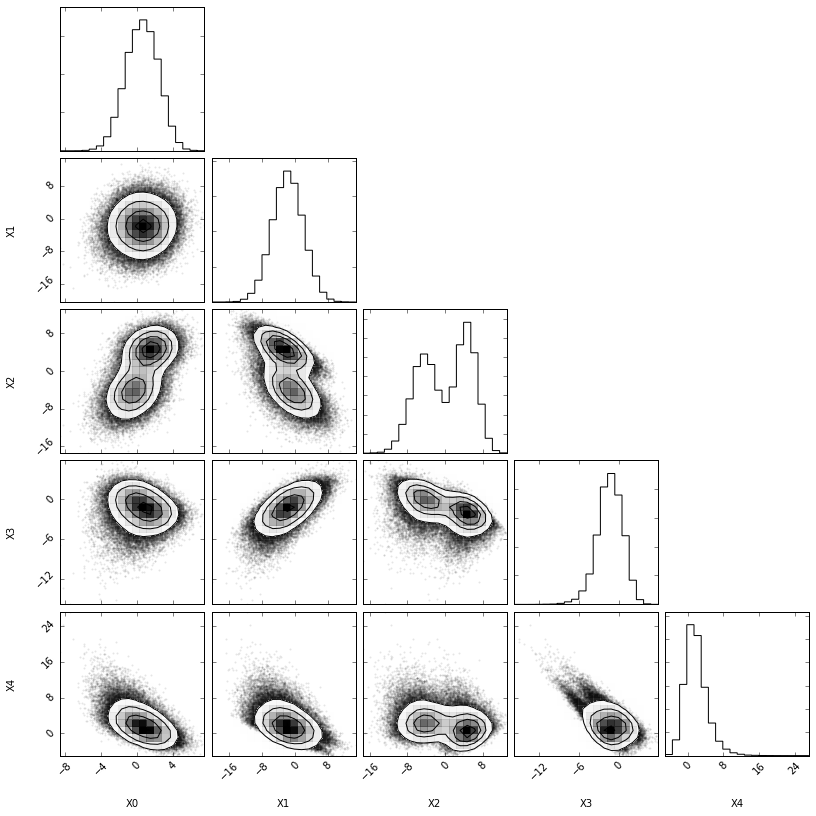

In [29]:
#plot the data
import corner
fig = corner.corner(X0, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])

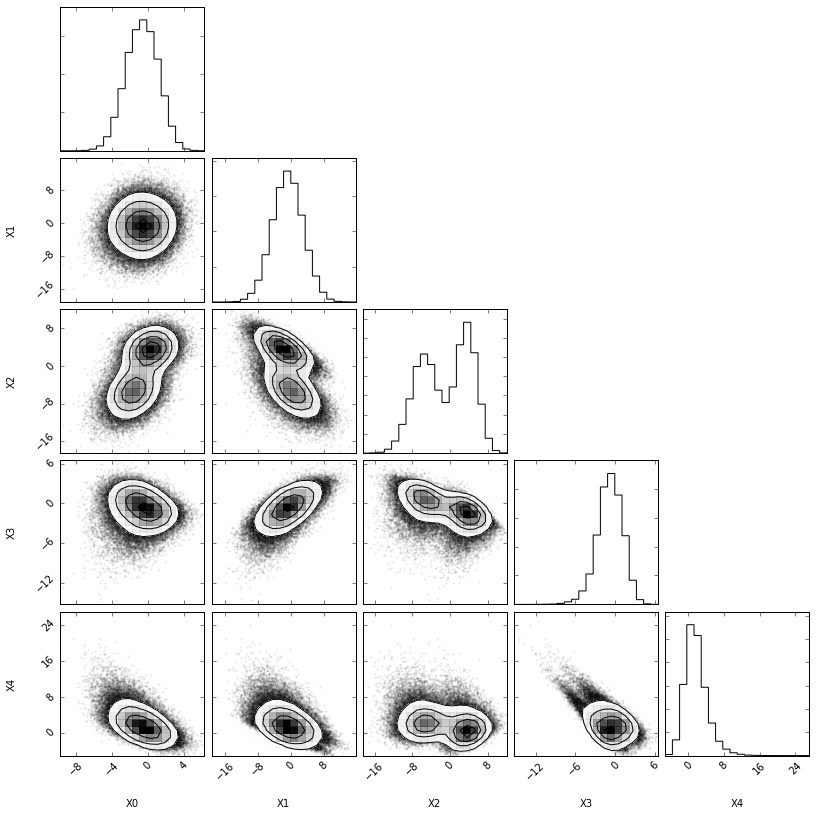

In [30]:
fig = corner.corner(X1, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])

### make a helper function for plotting the re-weighted data

In [31]:
hist_settings = {'bins': 50, 'normed': True, 'alpha': 0.3}
def draw_distributions(weights=np.ones(X0[:,0].size)):
    plt.figure(figsize=(16, 8))
    columns = range(5)
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack(X1[:,column]), [0.01, 99.99])
        plt.subplot(2,3, id)
        plt.hist(X0[:,column], weights=weights, range=xlim, color='b',**hist_settings)
        plt.hist(X1[:,column], range=xlim, color='orange',**hist_settings)
        plt.xlabel('X%d' %(id))

### The unweighted 1-d distributions

Clearly the distributions look different

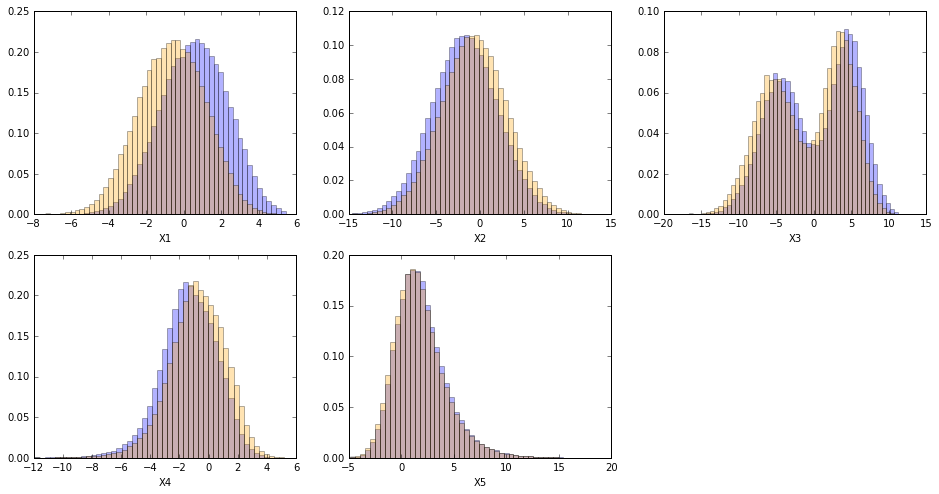

In [32]:
draw_distributions(np.ones(X0[:,0].size))

### Exact re-weighting

In this example, we know $p_0(x)$ and $p_1(x)$ exactly, so we can compare the other can compare the approximate reweighting approaches with the exact weights.

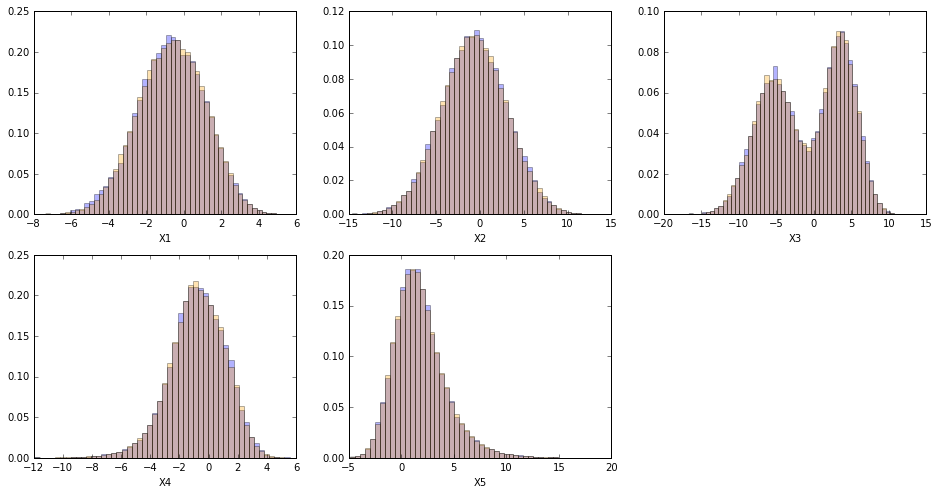

In [33]:
exact_weights = np.exp(p0.nnlf(X0) - p1.nnlf(X0))
draw_distributions(exact_weights)

Note that the distributions look very close, but they aren't exactly the same because of Poisson fluctuations 

### Gradient-boost re-weighting from hep_ml

See Alex Rogozhnikov's (Алексей Михайлович Рогожников)'s nice [blog post](http://arogozhnikov.github.io/2015/10/09/gradient-boosted-reweighter.html)

See also the [hep_ml documentation](https://arogozhnikov.github.io/hep_ml/reweight.html) for the tool.


And here is a [demo notebook](https://github.com/arogozhnikov/hep_ml/blob/master/notebooks/DemoReweighting.ipynb) similar to this one.

In [34]:
from hep_ml import reweight

In [35]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                   gb_args={'subsample': 0.6})
reweighter.fit(X0, X1)

gb_weights = reweighter.predict_weights(X0)


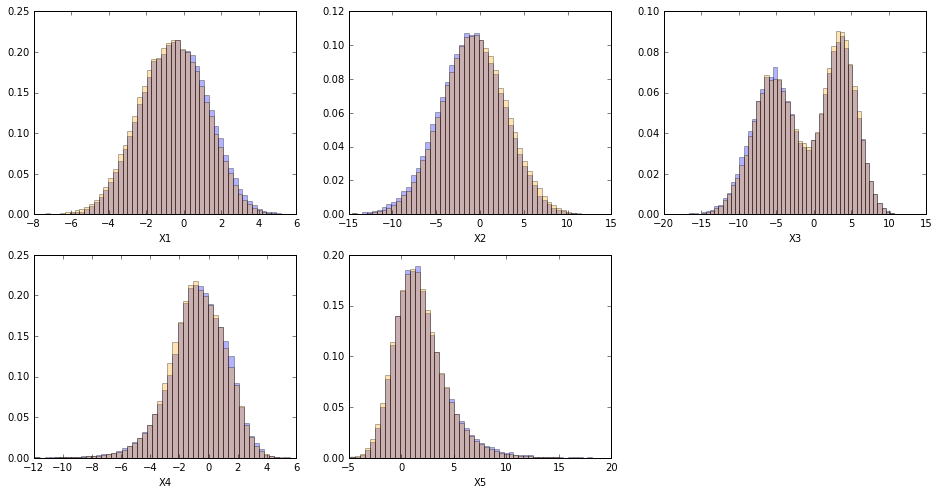

In [36]:
draw_distributions(gb_weights)

That looks pretty good, but of course those are 1-d projections. Later in the notebook we will train a classifier to try to distinguish the target and the reweighted distributions. But first, lets look at a scatter plot of the exact weights and the weights from the `GBReweighter`.

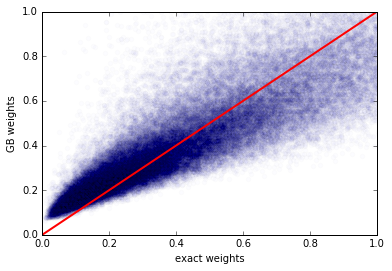

In [37]:
plt.scatter(exact_weights, gb_weights, alpha=0.01)
plt.plot([0,1],[0,1], lw=2, c='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('exact weights')
plt.ylabel('GB weights')

Pretty good, but notice that 

### Approximate likelihood ratio with classifiers

This approach is based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273). 

We will use the [carl](https://github.com/diana-hep/carl) package to approximate the likelihood ratio by first training a neural network classifier and then calibrating the output to be the likelihood ratio. Any other type of classifier could also be used.

In [38]:
from sklearn.neural_network import MLPRegressor
# other classifiers from scikit-learn that you could also use
#from sklearn.linear_model import ElasticNetCV
#from sklearn.ensemble import ExtraTreesRegressor

# for calibration
from sklearn.model_selection import StratifiedShuffleSplit
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV

In [39]:
classifier = MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)  # use 15 and 12 bins

cross_validation = StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=1)
ratio = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(classifier, cv=cross_validation,
                                          method="kde", bins=20), 
    random_state=0)

# now train the classifier and calibrate the ratio 
ratio.fit(numerator=p1, denominator=p0, n_samples=n_samples*2)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=MLPRegressor(activation='logistic', algorithm='l-bfgs', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=...r=1, random_state=1, test_size=0.5,
            train_size=None),
            eps=0.1, method='kde'),
        random_state=0)

In [40]:
# get the weights
carl_weights = ratio.predict(X0)

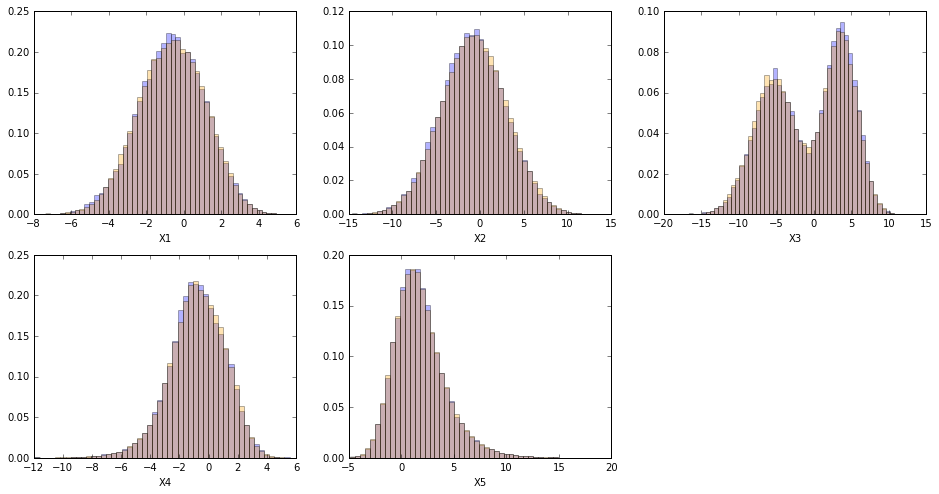

In [41]:
draw_distributions(carl_weights)

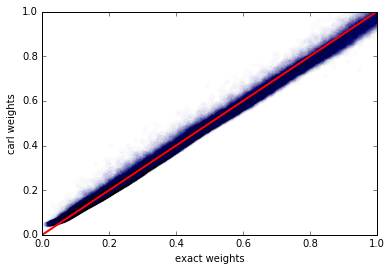

In [42]:
plt.scatter(exact_weights, carl_weights, alpha=0.01)
plt.plot([0,1],[0,1], lw=2, c='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('exact weights')
plt.ylabel('carl weights')

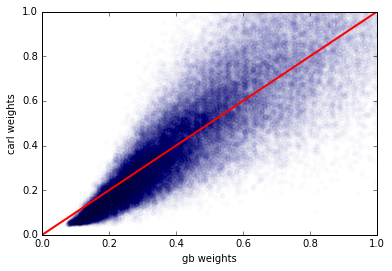

In [48]:
plt.scatter(gb_weights, carl_weights, alpha=0.01)
plt.plot([0,1],[0,1], lw=2, c='r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('gb weights')
plt.ylabel('carl weights')

## Histogram the weights: Common support diagnostic

One issue that comes up in reweighting is the issue of common support.
For reweighting to work $p_0(x)$ and $p_1(x)$ need need to have a *common support*, i.e. any sample $x$ could have come from either $p_0(x)$ or $p_1(x)$ with non-zero probability (density). If there is some region where the data $x$ could only have come from $p_1(x)$, then there is no way to reweight $p_0(x)$ to look like $p_1(x)$ in that region. 

Moreover, if the probability density for $p_0(x)$ is much less than $p_1(x)$ in some region, then the weights will be very large. This will lead to various types of instabilities in both the rewieghting procedure and in down-stream usage of the weighted samples. Very small weights indicate the opposite situation -- while it may be less of a worry given the asymmetry of the source and target distributions, it will mean that you are effectively throwing away the samples with very small weights.  So it's a good idea to look at the distribution of the weights. 

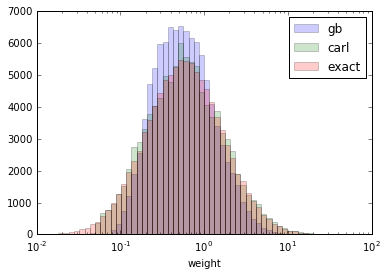

In [60]:
#histogram the weights with logarithmic binning
h = plt.hist((gb_weights),bins=np.exp(np.linspace(-4,3,50)),alpha=0.2,label="gb")
h = plt.hist((carl_weights),bins=np.exp(np.linspace(-4,3,50)),alpha=0.2,label="carl")
h = plt.hist((exact_weights),bins=np.exp(np.linspace(-4,3,50)),alpha=0.2,label="exact")
plt.semilogx()
plt.legend()
plt.xlabel("weight")

## ROC curves for quantitative assessment of performance

We want to quantify how well the reweighted distribution matches target distribution, but this is challenging in high dimensions. So we will train a new classifier, call it the *discriminator*, that will try to predict if an event is from the reweighted distribution or the real target. If it can tell the difference, then we haven't done a good job in reweighting. If we have done a good job in reweighting, then we don't expect that it will be able to tell the difference and the ROC curve should just be a diagonal line with Area Under the Curve (AUC) of 0.5. 

*Note*: This is similar to the use of the discriminator in the paper [Generative Adversarial Nets](http://arxiv.org/abs/1406.2661).

In [43]:
from sklearn.metrics import roc_curve, auc
def makeROC(predictions,targetdata):
    fpr, tpr, _  = roc_curve(targetdata.ravel(),predictions.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr,tpr,roc_auc

In [44]:
# obtain data from r*p1 by resampling data from p1 using r as weights
# fix conventions of p0 vs. p1 reweighting
def weight_data(x1,x0,weights):
    x1_len = x1.shape[0]
    weights = weights / weights.sum()
    weighted_data = np.random.choice(range(x1_len), x1_len, p = weights)
    w_x1 = x1.copy()[weighted_data]
    y = np.zeros(x1_len * 2)
    x_all = np.vstack((w_x1,x0))
    y_all = np.zeros(x1_len * 2)
    y_all[x1_len:] = 1
    return (x_all,y_all)

# generate some new data to make the ROC curve.
# if we used the same data we might be fooled by overfitting
X0_roc = p0.rvs(50000,random_state=777)
X1_roc = p1.rvs(50000,random_state=777)


# Weighted with true ratios
exact_weights_roc = np.exp(p0.nnlf(X0_roc) - p1.nnlf(X0_roc))
exact_weights_roc[np.isinf(exact_weights_roc)] = 0.
roc_data_exact_weights = weight_data(X0_roc,X1_roc,exact_weights_roc)

# Weighted with approximate likelihood ratios from carl
carl_weights_roc = ratio.predict(X1_roc,log=False)
carl_weights_roc[np.isinf(carl_weights_roc)] = 0.
roc_data_carl_weights = weight_data(X0_roc,X1_roc,carl_weights_roc)

# Weighted with GB ratios
gb_weights_roc = reweighter.predict_weights(X1_roc)
gb_weights_roc[np.isinf(gb_weights_roc)] = 0.
roc_data_gb_weights = weight_data(X0_roc,X1_roc,gb_weights_roc)

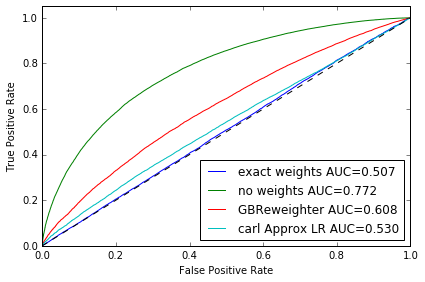

In [45]:
discriminator = MLPRegressor(tol=1e-05, activation="logistic", 
               hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
               learning_rate="constant", algorithm="l-bfgs", random_state=1, 
               max_iter=75)

discriminator.fit(roc_data_exact_weights[0],roc_data_exact_weights[1])
predicted = discriminator.predict(roc_data_exact_weights[0])
fpr_t,tpr_t,roc_auc_t = makeROC(predicted, roc_data_exact_weights[1])
plt.plot(fpr_t, tpr_t, label=r"exact weights AUC=%.3f" % roc_auc_t)

discriminator.fit(np.vstack((X0_roc,X1_roc)),roc_data_exact_weights[1])
predicted = discriminator.predict(np.vstack((X0_roc,X1_roc)))
fpr_f,tpr_f,roc_auc_f = makeROC(predicted, roc_data_exact_weights[1])
plt.plot(fpr_f, tpr_f, label=r"no weights AUC=%.3f" % roc_auc_f)

discriminator.fit(roc_data_gb_weights[0],roc_data_gb_weights[1])
predicted = discriminator.predict(roc_data_gb_weights[0])
fpr_a,tpr_a,roc_auc_a = makeROC(predicted, roc_data_gb_weights[1])
plt.plot(fpr_a, tpr_a, label=r"GBReweighter AUC=%.3f" % roc_auc_a)

discriminator.fit(roc_data_carl_weights[0],roc_data_carl_weights[1])
predicted = discriminator.predict(roc_data_carl_weights[0])
fpr_a,tpr_a,roc_auc_a = makeROC(predicted, roc_data_carl_weights[1])
plt.plot(fpr_a, tpr_a, label=r"carl Approx LR AUC=%.3f" % roc_auc_a)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()

plt.show()

The ROC curves tell a
similarly revealing story. As expected, the classifier is not able to
distinguish between the distributions when $p(\mathbf{x}|\theta_1)$ is weighted
by the exact likelihood ratio. We can also rule out that this is a deficiency in
the classifier because the two distributions are well separated when no weights
are applied to $p(\mathbf{x}|\theta_1)$. The `GBReweighter` does quite well, and for this problem the approximate liklehood ratio consructed with `carl` does significantly better. However, neither of them is perfect.

*Caution* I've not done any tuning for either of the methods. The `GBReweighter` was configured as in Alex's example and the classifier here is configured as in the other example notebooks for `carl`. YMMV.